In [ ]:
#############################################################
# CITATION:                                                 #
# The graphing code and the function                        #
# get_all_representations_as_matrix() was written for       #
# Charissa Plattner's CS 224U project in the Spring.        #
#############################################################

In [15]:
from collections import *
from numpy import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn.cluster
import sklearn.decomposition
import sklearn.feature_extraction.text
from sklearn.decomposition import PCA

from nltk.stem.snowball import SnowballStemmer
import nltk
import song_parsing

In [16]:
N_CLUSTERS = 3

desired_pos = ['IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 
    'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def get_all_words_and_word_counts(songs):
    stemmer = SnowballStemmer("english")
    all_words = set([])
    song_counters = {}
    for song in songs:
        words = []
        for line in songs[song].split('\n'):
            t = nltk.word_tokenize(line.decode('utf-8'))
            tagged = nltk.pos_tag(t)
            for word in tagged:
                if word[1] in desired_pos:
                    words.append(word[0])
                                
        stemmed = []
        for word in words: 
            try:
                stem = stemmer.stem(word)
            except:
                stem = word
            stemmed.append(stem)
                            
        counter = Counter(stemmed)
        song_counters[song] = counter
        all_words = all_words.union( counter.iterkeys() )

    all_words = sorted(all_words)
    return all_words, song_counters
    
def get_all_representations_as_matrix(songs, song_counters, all_words):
    all_song_representations = [[] for i in range(len(songs))]
    for word in all_words:
        for song_index, song in enumerate(songs):
            all_song_representations[song_index].append(song_counters[song[0]][word] * 1.0) 
    return all_song_representations
    
def get_clusters(songs):
    all_words, song_counters = get_all_words_and_word_counts(songs)
    songs = list(songs.iteritems())

    all_song_representations = get_all_representations_as_matrix(songs, song_counters, all_words)
        
    #TF-IDF
    tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm='l2',smooth_idf=True)
    communities = tfidf.fit_transform(all_song_representations).toarray()

    #SVD
    svd = sklearn.decomposition.TruncatedSVD(n_components=len(all_song_representations[0])/2)
    all_song_representations = svd.fit_transform(communities)
        
    clusterer = sklearn.cluster.KMeans(n_clusters=N_CLUSTERS, max_iter=500) #make max_iter higher later
    all_song_representations = np.array(all_song_representations) # as NP array
    cluster_labels = clusterer.fit_predict(all_song_representations)
    
    clusters = {}
    for song_index, cluster in enumerate(cluster_labels):
        if cluster not in clusters:
            clusters[cluster] = [songs[song_index][0]]
        else:
            clusters[cluster].append(songs[song_index][0])
    return all_song_representations, clusters, cluster_labels

In [32]:
songs = song_parsing.get_all_song_lyrics("Ariana Grande")

In [33]:
all_song_reps, clusters, cluster_labels = get_clusters(songs)

In [34]:
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
t = svd.fit_transform(all_song_reps)

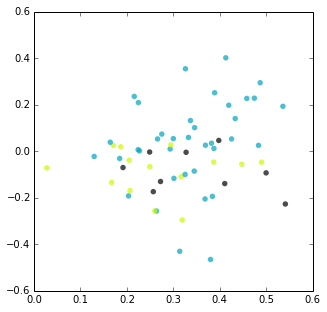

In [35]:
%matplotlib inline
plt.figure(figsize=(5,5))
colors = cm.spectral(cluster_labels.astype(float) / N_CLUSTERS)
plt.scatter(t[:, 0], t[:, 1], marker='.', s=120, lw=0, alpha=0.7, c=colors)
plt.show()

In [36]:
print Counter(cluster_labels)
for cluster in clusters:
    print clusters[cluster]

Counter({1: 37, 2: 14, 0: 9})
['Love Me Harder', 'The Way', "Lovin' It", 'Stick Around', 'ABC', 'Emotions', 'Problem', 'Baby I', 'Right There']
['My Everything', 'Almost Is Never Enough', 'The Beauty Within You', 'Daydreaming', 'Love The Way You Lie', 'Only 1', 'Just A Little Bit Of Your Heart', 'Brand New You', 'Santa Tell Me', 'Vienna', 'Popular Song', 'Love Is Everything', 'Snow In California', 'Break Free', 'Too Close', 'Honeymoon Avenue', 'Intro', "You're My Only Shawty", 'Why Try', 'Break Your Heart Right Back', "Daydreamin'", 'Santa Baby', 'Cadillac Song', "You'll Never Know", 'Suitcase', 'Grenade', "You Don't Know Me", 'Zero To Hero', 'Last Christmas', 'Voodoo Love', 'One Last Time', 'Be My Baby', 'I Have Nothing', 'The Way (Spanglish Version)', 'Tattooed Heart', "I Don't Want To Be Alone For Christmas", 'Die In Your Arms']
['Boyfriend Material', 'Put Your Hearts Up', 'Only Girl (In The World)', 'Best Mistake', 'Piano', 'Higher', 'Pink Champagne', 'Hands On Me', 'Do You Love Me